Harshani Rathnayake

Project 2: Python Code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

**Part 1:**

Value function by solving Bellman equations:
[[ 2.17  4.73  2.07  1.27  1.78]
 [ 1.12  1.78  1.17  0.74  0.56]
 [ 0.16  0.48  0.35  0.11 -0.19]
 [-0.55 -0.28 -0.28 -0.44 -0.74]
 [-1.11 -0.85 -0.81 -0.94 -1.24]]

Highest value: 4.73
States with highest value (index): [1]
Positions (row,col): [(np.int64(0), np.int64(1))]

Value function by iterative policy evaluation:
[[ 2.17  4.73  2.07  1.27  1.78]
 [ 1.12  1.78  1.17  0.74  0.56]
 [ 0.16  0.48  0.35  0.11 -0.19]
 [-0.55 -0.28 -0.28 -0.44 -0.74]
 [-1.11 -0.85 -0.81 -0.94 -1.24]]

Optimal value function (policy iteration):
[[21.   22.1  21.   19.95 18.38]
 [19.95 21.   19.95 18.95 18.  ]
 [18.95 19.95 18.95 18.   17.1 ]
 [18.   18.95 18.   17.1  16.25]
 [17.1  18.   17.1  16.25 15.43]]

Optimal policy (0:U,1:D,2:L,3:R):
[[3 0 2 2 0]
 [0 0 0 0 2]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]

Optimal value function (value iteration):
[[21.   22.1  21.   19.95 18.38]
 [19.95 21.   19.95 18.95 18.  ]
 [18.95 19.95 18.95 18.   17.1 ]
 [18.   18.9

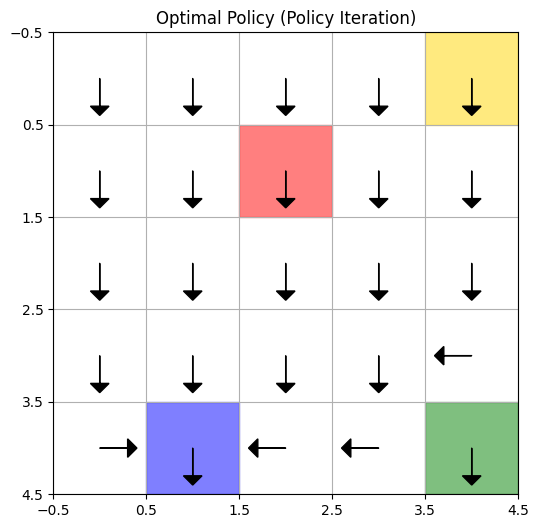

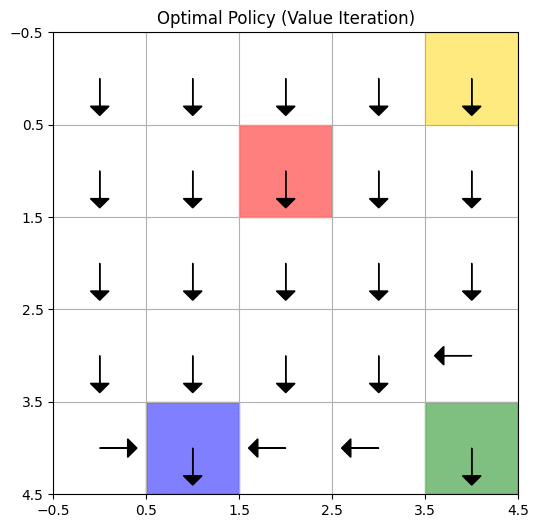

Are policies from policy iteration and value iteration identical?: True
Differences between policies (True = different):
[[False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]]


In [ ]:
#Defined gridworld environment:
grid_size = 5  #5x5 grid
gamma = 0.95 #reward discount factor
actions = ['U', 'D', 'L', 'R']  #action space: Up, Down, Left, Right
action_prob = 0.25 #uniform random policy: equal probability for each action

#Helper: This convert (row, col) to state index
def to_state(row, col):
    return row * grid_size + col

#Special states defined by the problem statement
blue = (0,1)  #first row, second column
green = (0,4)  #first row, fifth column
red = (3,2)  #fourth row, third column
yellow = (4,4)   #fifth row, fifth column

#Converts the special states to indices:
blue_s = to_state(*blue)
green_s = to_state(*green)
red_s = to_state(*red)
yellow_s = to_state(*yellow)

#Total number of states
n_states = grid_size * grid_size

#Initialized transition probability (P) and reward (R) tensors
#Dimensions: [state, action, next_state]
P = np.zeros((n_states, len(actions), n_states))
R = np.zeros((n_states, len(actions), n_states))

#Build environment dynamics (transition + reward model)
for row in range(grid_size):
    for col in range(grid_size):
        s = to_state(row, col)
        for a_idx, a in enumerate(actions):
            #Special state: blue square always jumps to red with reward 5
            if s == blue_s:
                next_s = red_s
                P[s,a_idx,next_s] = 1.0
                R[s,a_idx,next_s] = 5
            #Special state: green square jumps randomly to yellow or red with reward 2.5
            elif s == green_s:
                P[s,a_idx,red_s] = 0.5
                P[s,a_idx,yellow_s] = 0.5
                R[s,a_idx,red_s] = 2.5
                R[s,a_idx,yellow_s] = 2.5
            else:
                #Regular square: compute next position after action
                if a == 'U':
                    next_row = max(row-1,0)
                    next_col = col
                elif a == 'D':
                    next_row = min(row+1,grid_size-1)
                    next_col = col
                elif a == 'L':
                    next_row = row
                    next_col = max(col-1,0)
                elif a == 'R':
                    next_row = row
                    next_col = min(col+1,grid_size-1)
                next_s = to_state(next_row, next_col)
                #Below checks if move hits border:
                if next_row == row and next_col == col and (
                    (row==0 and a=='U') or
                    (row==grid_size-1 and a=='D') or
                    (col==0 and a=='L') or
                    (col==grid_size-1 and a=='R')):
                    P[s,a_idx,next_s] = 1.0
                    R[s,a_idx,next_s] = -0.5  #penalty for trying to step off grid
                else:
                    P[s,a_idx,next_s] = 1.0
                    R[s,a_idx,next_s] = 0   #normal move with zero reward


#(1) Solve Bellman equations explicitly
#Compute expected transition matrix P_pi and expected reward R_pi under uniform policy
P_pi = np.zeros((n_states, n_states))
R_pi = np.zeros(n_states)

for s in range(n_states):
    for a_idx in range(len(actions)):
        for next_s in range(n_states):
            P_pi[s,next_s] += action_prob * P[s,a_idx,next_s]
            R_pi[s] += action_prob * P[s,a_idx,next_s] * R[s,a_idx,next_s]

#Solve linear system: V = (I - gamma * P_pi)^(-1) * R_pi
I = np.eye(n_states)
V_explicit = np.linalg.solve(I - gamma * P_pi, R_pi)
print("Value function by solving Bellman equations:")
print(np.round(V_explicit.reshape((grid_size,grid_size)),2))

#Find highest value states
max_val = np.max(V_explicit)
max_states = np.argwhere(np.isclose(V_explicit, max_val)).flatten()
positions = [(s // grid_size, s % grid_size) for s in max_states]
print(f"\nHighest value: {max_val:.2f}")
print("States with highest value (index):", max_states)
print("Positions (row,col):", positions)

#(2) Iterative policy evaluation under uniform random policy
#Goal: Estimate value function V(s) assuming the agent picks each action with equal probability
V = np.zeros(n_states) #Initialize value function: all zeros
theta = 1e-6  #Convergence threshold: stop when changes are very small
while True:
    delta = 0 #Track the maximum change in V across all states
    V_new = np.zeros_like(V)  #Temporary array to store new value estimates
    #Loop over all states
    for s in range(n_states):
        v = 0  #To accumulate expected return for state s under uniform random policy
        #Loop over all possible actions
        for a_idx in range(len(actions)):
            #Loop over all possible next states
            for next_s in range(n_states):
                #Expected contribution:
                #action_prob × transition probability × [reward + γ × value of next state]
                v += action_prob * P[s, a_idx, next_s] * (R[s, a_idx, next_s] + gamma * V[next_s])
        V_new[s] = v  #Update value for state s
        #Update delta to track the largest difference from previous iteration
        delta = max(delta, abs(V_new[s] - V[s]))
    V = V_new  #Update value function for next iteration
    #Check for convergence: if max change is below threshold, stop
    if delta < theta:
        break
#Display final estimated value function
print("\nValue function by iterative policy evaluation:")
print(np.round(V.reshape((grid_size,grid_size)),2))

#(3) Policy iteration: alternating between policy evaluation and improvement
#Initialize policy: start by always taking action 0
policy = np.zeros(n_states, dtype=int)
#Initialize value function: start with all zeros
V_pi = np.zeros(n_states)
while True:
    #Step 1: Policy Evaluation
    #Compute value function V_pi for the current fixed policy until it converges
    while True:
        delta = 0   #Track maximum change to check convergence
        V_new = np.zeros_like(V_pi)  #Temporary array for updated values
        #Loop over each state to update value
        for s in range(n_states):
            a_idx = policy[s]  #action chosen by current policy in state s
            #Compute expected return:
            #sum over next states of P(s,a,next_s) * (reward + γ * V[next_s])
            v = sum(
                P[s, a_idx, next_s] * (R[s, a_idx, next_s] + gamma * V_pi[next_s])
                for next_s in range(n_states)
            )
            V_new[s] = v
            #Update delta to track largest change
            delta = max(delta, abs(V_new[s] - V_pi[s]))
        V_pi = V_new  #update value function
        #Stop policy evaluation if value function converged (small changes only)
        if delta < theta:
            break

    #Step 2: Policy Improvement
    #Update policy to be greedy w.r.t. current value function V_pi
    policy_stable = True  #Flag to check if policy changes in this step
    for s in range(n_states):
        old_action = policy[s] #remember old action to compare later
        #Compute expected return for each possible action
        action_values = np.zeros(len(actions))
        for a_idx in range(len(actions)):
            action_values[a_idx] = sum(
                P[s, a_idx, next_s] * (R[s, a_idx, next_s] + gamma * V_pi[next_s])
                for next_s in range(n_states)
            )
        #Choose the action with highest expected return
        best_action = np.argmax(action_values)
        policy[s] = best_action
        #If policy changed, mark as unstable so we keep iterating
        if old_action != best_action:
            policy_stable = False
    #If policy didn't change for any state, we have found the optimal policy
    if policy_stable:
        break
#Display final results
print("\nOptimal value function (policy iteration):")
print(np.round(V_pi.reshape((grid_size,grid_size)),2))
print("\nOptimal policy (0:U,1:D,2:L,3:R):")
print(policy.reshape((grid_size,grid_size)))

#(4) Value iteration to compute optimal value function and policy
#Initialize value function: start with all zeros
V_vi = np.zeros(n_states)
while True:
    delta = 0     #Tracks max change in value function to check for convergence
    V_new = np.zeros_like(V_vi)  #Temporary array to store new value estimates
    #Loop over each state to update its value
    for s in range(n_states):
        action_values = np.zeros(len(actions))   #Store expected return for each possible action
        #For each action, compute expected return:
        #sum over all possible next states: P(s,a,next_s) * [ R(s,a,next_s) + γ * V(next_s) ]
        for a_idx in range(len(actions)):
            action_values[a_idx] = sum(
                P[s, a_idx, next_s] * (R[s, a_idx, next_s] + gamma * V_vi[next_s])
                for next_s in range(n_states)
            )
        #Choose the maximum expected return among actions → Bellman optimality update
        V_new[s] = np.max(action_values)
        #Update delta to see how much V changed
        delta = max(delta, abs(V_new[s] - V_vi[s]))
    #Update value function
    V_vi = V_new
    #Check for convergence: if changes are smaller than small threshold theta, stop
    if delta < theta:
        break

#Extract optimal policy from final value function
policy_vi = np.zeros(n_states, dtype=int)   #Array to store best action per state
for s in range(n_states):
    action_values = np.zeros(len(actions))
    #For each action, compute expected return as before
    for a_idx in range(len(actions)):
        action_values[a_idx] = sum(
            P[s, a_idx, next_s] * (R[s, a_idx, next_s] + gamma * V_vi[next_s])
            for next_s in range(n_states)
        )
    #Best action is the one with highest expected return
    policy_vi[s] = np.argmax(action_values)
#Display results
print("\nOptimal value function (value iteration):")
print(np.round(V_vi.reshape((grid_size,grid_size)),2))
print("\nOptimal policy (0:U,1:D,2:L,3:R):")
print(policy_vi.reshape((grid_size,grid_size)))

#Plot function to visualize policy as arrows
def plot_policy(policy, title):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xlim(-0.5, grid_size-0.5)
    ax.set_ylim(-0.5, grid_size-0.5)
    ax.set_xticks(np.arange(-0.5, grid_size, 1))
    ax.set_yticks(np.arange(-0.5, grid_size, 1))
    ax.grid(True)
    ax.set_title(title)
    #Draw special squares
    special_states = {
        'blue': (blue, 'blue'),
        'green': (green, 'green'),
        'red': (red, 'red'),
        'yellow': (yellow, 'gold')
    }
    for name, (pos, color) in special_states.items():
        row, col = pos
        ax.add_patch(plt.Rectangle((col-0.5, grid_size - row -1 -0.5), 1, 1, color=color, alpha=0.5))
    #Draw arrows for each state's chosen action
    action_to_delta = {
        0: (0, +0.3), #U
        1: (0, -0.3), #D
        2: (-0.3, 0), #L
        3: (+0.3, 0) #R
    }
    for row in range(grid_size):
        for col in range(grid_size):
            s = to_state(row,col)
            a = a = policy[s] if np.isscalar(policy[s]) else np.argmax(policy[s])
            dx, dy = action_to_delta[a]
            plot_row = grid_size - row -1
            ax.arrow(col, plot_row, dx, dy, head_width=0.2, head_length=0.1, fc='k', ec='k')
    plt.gca().invert_yaxis()
    plt.show()

#Plots the optimal policies found
plot_policy(policy, "Optimal Policy (Policy Iteration)")
plot_policy(policy_vi, "Optimal Policy (Value Iteration)")

#Compare policies: are they identical or not
same = np.all(policy == policy_vi)
print("Are policies from policy iteration and value iteration identical?:", same)
#Show where they differ:
diff = (policy != policy_vi).reshape((grid_size, grid_size))
print("Differences between policies (True = different):")
print(diff)

**Part 2:**

MC with exploring starts - learned policy:
[[2 0 1 0 0]
 [1 1 1 3 1]
 [0 2 3 3 0]
 [0 2 0 0 0]
 [0 2 1 1 0]]


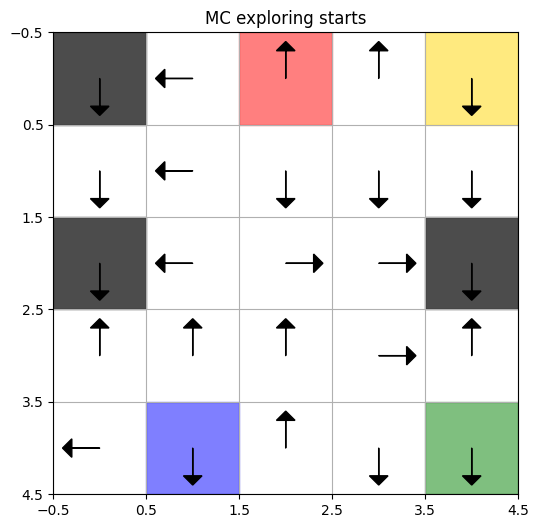


Value function from MC with exploring starts:
[[-0.5  -4.21 -0.73 -0.62 -1.38]
 [-0.2  -0.37 -0.59 -0.49 -0.2 ]
 [ 0.   -0.2  -0.4  -0.2   0.  ]
 [-0.2  -0.39 -0.59 -0.38 -0.2 ]
 [ 0.   -0.2  -0.5  -0.5  -0.39]]

MC with ε-soft policy - learned policy:
[[3 1 2 2 1]
 [0 3 0 2 2]
 [0 0 1 0 0]
 [3 0 0 0 2]
 [0 0 1 0 2]]


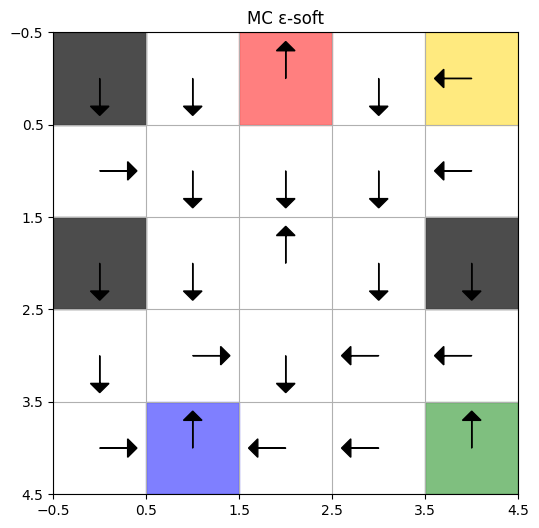


Value function from MC with ε-soft:
[[ 3.05  2.83  2.34  1.77  1.72]
 [ 2.49  1.71  1.53  1.2   1.32]
 [ 0.    1.17  1.01  0.7   0.  ]
 [ 0.81  0.5   0.2   0.15  0.3 ]
 [ 0.    0.13 -0.77 -0.38  0.15]]

Off-policy MC with importance sampling - learned policy:
[[0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 1]
 [0 0 0 0 0]]


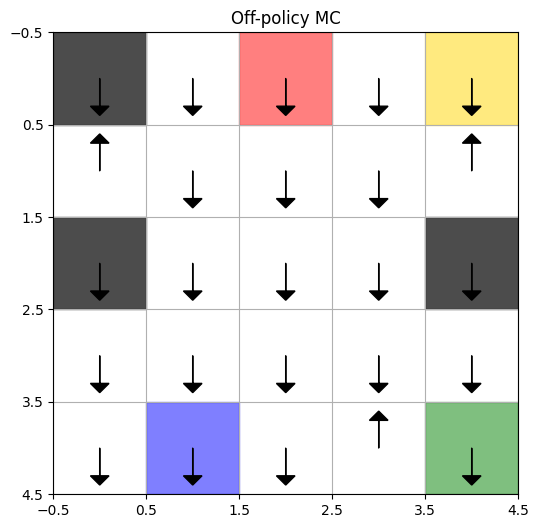

In [ ]:
#Define gridworld and parameters
grid_size = 5  #Gridworld is 5x5 cells
gamma = 0.95  #Discount factor: future rewards are worth 95% as much
actions = ['U', 'D', 'L', 'R']  #Action set: Up, Down, Left, Right
action_idx = {a:i for i,a in enumerate(actions)}  #Helper: map actions to indices for array indexing

#Define special colored squares (positions are (row, col) starting from 0)
blue = (0, 1) #first row, second column
green = (0, 4) #first row, fifth column
red = (4, 2) #last row, third column
yellow = (4, 4)  #last row, last column
#Terminal (black) squares where episode ends immediately when agent steps in
black_terminals = [
    (2, 0), #third row, first column
    (2, 4), #third row, last column
    (4, 0)  #last row, first column
]

#Convert positions (row, col) to state indices (flattened index)
blue_s = blue[0]*grid_size + blue[1]
green_s = green[0]*grid_size + green[1]
red_s = red[0]*grid_size + red[1]
yellow_s = yellow[0]*grid_size + yellow[1]
black_s = [r*grid_size + c for (r, c) in black_terminals]  #list of terminal state indices
n_states = grid_size * grid_size   #total number of states in grid

#Initialize starting policy: uniform random policy
#Each state: equal probability for each action
policy = np.ones((n_states, len(actions))) / len(actions)

#Function to simulate a single episode in the Gridworld environment under a given policy
#Parameters:
 #policy : current policy, mapping each state to a probability distribution over actions
 #exploring_starts : if True, start from a random non-terminal state and random action
 #max_steps : maximum number of steps to run in an episode to prevent infinite loops
 #episode  : list of (state, action, reward) tuples representing the trajectory
def generate_episode(policy, exploring_starts=False, max_steps=100):
    episode = []  #list to store the sequence of (state, action, reward)
    #Choose starting state and starting action
    if exploring_starts:
        #For exploring starts: start from a random non-terminal state and a random action
        s = random.choice([s for s in range(n_states) if s not in black_s])
        a = random.choice(range(len(actions)))
    else:
        #Otherwise: start from a random non-terminal state and select action according to the current policy
        s = random.choice([s for s in range(n_states) if s not in black_s])
        a = np.random.choice(len(actions), p=policy[s])
    #Loop to simulate the episode, step by step
    for _ in range(max_steps):
        #Convert flattened state index to (row, col) coordinates
        row, col = divmod(s, grid_size)
        #Check if current state is a terminal state (black square): if yes, episode ends
        if s in black_s:
            break
        #Check for special colored squares and apply special transitions and rewards
        if s == blue_s:
            reward = 5  #reward for blue square
            next_s = red_s   #teleport to red square
        elif s == green_s:
            reward = 2.5   #reward for green square
            #teleport randomly to red or yellow square
            next_s = np.random.choice([red_s, yellow_s])
        else:
            #For normal white squares: determine next position based on action
            if actions[a] == 'U': #move up
                next_row = max(row-1, 0)
                next_col = col
            elif actions[a] == 'D':  #move down
                next_row = min(row+1, grid_size-1)
                next_col = col
            elif actions[a] == 'L': #move left
                next_row = row
                next_col = max(col-1, 0)
            else:       #move right ('R')
                next_row = row
                next_col = min(col+1, grid_size-1)
            #Check if the agent attempted to step off the grid (hit the wall)
            if next_row == row and next_col == col and (
                (row==0 and actions[a]=='U') or
                (row==grid_size-1 and actions[a]=='D') or
                (col==0 and actions[a]=='L') or
                (col==grid_size-1 and actions[a]=='R')):
                reward = -0.5   # penalty for hitting the wall
            else:
                reward = -0.2 #penalty for moving from white square to white square
          #Convert next (row, col) to flattened state index
            next_s = next_row * grid_size + next_col
        #Add the current step to the episode list
        episode.append((s, a, reward))
        # Move to the next state
        s = next_s
        # Check again if the new state is a terminal state: if yes, episode ends
        if s in black_s:
            break
        #Choose next action in the new state according to the current policy
        a = np.random.choice(len(actions), p=policy[s])
    #Return the full episode: list of (state, action, reward)
    return episode

#Helper for policy iteration (not Monte Carlo): build P_pi and R_pi under deterministic policy
def build_P_pi_and_R_pi(policy, P, R):
    P_pi = np.zeros((n_states, n_states))  #transition matrix under policy
    R_pi = np.zeros(n_states)   #expected reward vector under policy
    for s in range(n_states):
        a = policy[s]  #deterministic action chosen in state s
        P_pi[s, :] = P[s, a, :]  #probabilities of next states
        R_pi[s] = np.sum(P[s, a, :] * R[s, a, :])  #expected immediate reward
    return P_pi, R_pi

#Policy iteration using explicit matrix inversion (solve Bellman equations)
def policy_iteration_explicit(P, R, gamma, policy, max_iters=100):
    for i in range(max_iters):
        #Step 1: Policy evaluation
        P_pi, R_pi = build_P_pi_and_R_pi(policy, P, R)
        I = np.eye(n_states)
        V = np.linalg.solve(I - gamma * P_pi, R_pi)  #solve V = (I - gamma*P_pi)^(-1) * R_pi
        #Step 2: Policy improvement
        policy_stable = True
        for s in range(n_states):
            action_values = np.zeros(len(actions))
            for a in range(len(actions)):
                #expected return if we take action a in state s
                action_values[a] = np.sum(P[s, a, :] * (R[s, a, :] + gamma * V))
            best_action = np.argmax(action_values)
            if best_action != policy[s]:
                policy[s] = best_action
                policy_stable = False
        if policy_stable:
            print(f"Policy converged after {i+1} iterations")
            break
    return policy, V

#Same plot function as before, but with the black terminal squares
def plot_policy(policy, title):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xlim(-0.5, grid_size-0.5)
    ax.set_ylim(-0.5, grid_size-0.5)
    ax.set_xticks(np.arange(-0.5, grid_size, 1))
    ax.set_yticks(np.arange(-0.5, grid_size, 1))
    ax.grid(True)
    ax.set_title(title)
    #Draw special squares
    special_states = {
        'blue': (blue, 'blue'),
        'green': (green, 'green'),
        'red': (red, 'red'),
        'yellow': (yellow, 'gold')
    }
    for name, (pos, color) in special_states.items():
        row, col = pos
        ax.add_patch(plt.Rectangle((col-0.5, grid_size - row -1 -0.5), 1, 1, color=color, alpha=0.5))
    #NEW: Draw black terminal squares
    for (row, col) in black_terminals:
        ax.add_patch(plt.Rectangle((col-0.5, grid_size - row -1 -0.5), 1, 1, color='black', alpha=0.7))
    #Draw arrows for policy
    action_to_delta = {
        0: (0, +0.3), #U
        1: (0, -0.3), #D
        2: (-0.3, 0), #L
        3: (+0.3, 0) #R
    }
    for row in range(grid_size):
        for col in range(grid_size):
            s = row * grid_size + col
            a = a = policy[s] if np.isscalar(policy[s]) else np.argmax(policy[s])
            dx, dy = action_to_delta[a]
            plot_row = grid_size - row -1
            ax.arrow(col, plot_row, dx, dy, head_width=0.2, head_length=0.1, fc='k', ec='k')
    plt.gca().invert_yaxis()
    plt.show()

#(1) Monte Carlo control with exploring starts (start random state/action)
Q = np.zeros((n_states, len(actions)))       # Action-value function
returns_count = np.zeros((n_states, len(actions)))  # Count of visits per (s,a)
for i in range(5000):   #number of episodes
    episode = generate_episode(policy, exploring_starts=True)
    G = 0   #return (discounted sum of rewards)
    visited = set()   #to only update first visit in each (s,a)
    for s, a, r in reversed(episode):
        G = gamma*G + r
        if (s,a) not in visited:
            returns_count[s,a] += 1
            #Incremental mean update
            Q[s,a] += (G - Q[s,a]) / returns_count[s,a]
            best_a = np.argmax(Q[s])
            #Update policy: greedy in Q
            policy[s] = np.eye(len(actions))[best_a]
            visited.add((s,a))
print("MC with exploring starts - learned policy:")
print(np.argmax(policy, axis=1).reshape((grid_size, grid_size)))
plot_policy(np.argmax(policy, axis=1), "MC exploring starts")
#Compute value function as max_a Q(s,a)
V_mc_es = np.max(Q, axis=1)
print("\nValue function from MC with exploring starts:")
print(np.round(V_mc_es.reshape((grid_size, grid_size)), 2))


#(2) Monte Carlo control with ε-soft policy
Q2 = np.zeros((n_states, len(actions)))
returns2 = np.zeros((n_states, len(actions)))
epsilon = 0.1
policy2 = np.ones((n_states, len(actions))) / len(actions)  #start equiprobable
for i in range(5000):
    episode = generate_episode(policy2)
    G = 0
    visited = set()
    for s,a,r in reversed(episode):
        G = gamma*G + r
        if (s,a) not in visited:
            returns2[s,a] += 1
            Q2[s,a] += (G - Q2[s,a]) / returns2[s,a]
            best_a = np.argmax(Q2[s])
            #ε-soft policy update: mostly greedy, small prob for others
            for a_idx in range(len(actions)):
                if a_idx == best_a:
                    policy2[s,a_idx] = 1 - epsilon + epsilon/len(actions)
                else:
                    policy2[s,a_idx] = epsilon/len(actions)
            visited.add((s,a))

print("\nMC with ε-soft policy - learned policy:")
print(np.argmax(policy2, axis=1).reshape((grid_size, grid_size)))
plot_policy(np.argmax(policy2, axis=1), "MC ε-soft")
V_mc_soft = np.max(Q2, axis=1)
print("\nValue function from MC with ε-soft:")
print(np.round(V_mc_soft.reshape((grid_size, grid_size)),2))

#(3) Off-policy MC with importance sampling
target_policy = np.zeros((n_states, len(actions)))  #target policy we want to learn: greedy in Q
Q3 = np.zeros((n_states, len(actions)))  #action-value estimates
C = np.zeros((n_states, len(actions))) #cumulative sum of importance weights
#Initialize target policy as uniform
for s in range(n_states):
    target_policy[s] = np.ones(len(actions)) / len(actions)
for i in range(5000):
    episode = generate_episode(policy)  #generate episode using behavior policy (here, policy is uniform)
    G = 0
    W = 1
    for s,a,r in reversed(episode):
        G = gamma*G + r
        C[s,a] += W
        Q3[s,a] += (W/C[s,a])*(G - Q3[s,a])  #weighted update
        best_a = np.argmax(Q3[s])
        #Make target policy greedy in Q
        target_policy[s] = np.eye(len(actions))[best_a]
        if a != best_a:
            break   #stop if action taken is different from greedy: importance weight becomes 0
        W = W / policy[s,a]  #update importance weight
print("\nOff-policy MC with importance sampling - learned policy:")
print(np.argmax(target_policy, axis=1).reshape((grid_size, grid_size)))
plot_policy(np.argmax(target_policy, axis=1), "Off-policy MC")